<a href="https://colab.research.google.com/github/aayush17125/Informed-RRT-star/blob/main/Informed-RRT-star.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import numpy as np 
import math 
import copy 
import matplotlib.pyplot as plt
import time


class Node():

    def __init__(self, x, y):
        self.x = x 
        self.y = y
        self.cost = 0.0 
        self.parent = None 


class RRT_Type():

    def __init__(self, start, goal, obstacleList, randArea, delta=0.5, goalSampleRate=10, maxIter=1000):

        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.minrand = randArea[0]
        self.maxrand = randArea[1]
        self.delta = delta
        self.goalSampleRate = goalSampleRate
        self.maxIter = maxIter
        self.obstacleList = obstacleList

#RRT
##################################################################################
    def RRT(self, animation=True):
        self.nodeList = [self.start]
        while True: 
            # get random point in the free space
            rnd = self.getPointSpace()
            # find closest node in the tree
            nind  = self.getNearestListIndex(self.nodeList, rnd)
            nearestNode = self.nodeList[nind]
            theta = math.atan2(rnd[1] - nearestNode.y, rnd[0] - nearestNode.x)
            # compute the position of the new node
            newNode = self.getNewNode(theta, nind, nearestNode)
            # collision check
            if not self.__CollisionCheck(newNode, self.obstacleList):
                continue 
            # if collision doesn't happen in extending the nearest node to the new node
            # add it to the tree
            self.nodeList.append(newNode)

            #check if we reached the goal 
            if self.isNearGoal(newNode):
                break

            if animation:
                self.plotter(rnd)

        # compute the path 
        lastIndex = len(self.nodeList) -1 
        path = self.getFinalCourse(lastIndex)

        return path 

    def getPointSpace(self):
        if random.randint(0,100) > self.goalSampleRate:
            rnd = [random.uniform(self.minrand, self.maxrand),
                   random.uniform(self.minrand, self.maxrand)]
        else:
            rnd = [self.goal.x, self.goal.y]

        return rnd

    def getNearestListIndex(self, nodes, rnd):
        dList = [(node.x - rnd[0])**2 + 
                 (node.y - rnd[1])**2 for node in nodes]
        minIndex = dList.index(min(dList))
        return minIndex

    def getNewNode(self, theta, nind, nearestNode):
        newNode = copy.deepcopy(nearestNode)

        newNode.x += self.delta * math.cos(theta)
        newNode.y += self.delta * math.sin(theta)

        newNode.cost += self.delta
        newNode.parent = nind 
        return newNode

    def __CollisionCheck(self, newNode, obstacleList):
        for (ox, oy, size) in obstacleList:
            dx = ox - newNode.x 
            dy = oy - newNode.y 
            d = (dx**2  + dy**2)**0.5
            if d <= size:
                return False #collision

        return True # safe

    def isNearGoal(self, node):
        d = self.lineCost(node, self.goal)
        if d < self.delta:
            return True 
        return False  

# RRT*
##################################################################################
    def RRTStar(self, animation=True):
        self.nodeList = [self.start]
        iter = 1
        while True:
            rnd = self.getPointSpace()
            nind = self.getNearestListIndex(self.nodeList, rnd)
            nearestNode = self.nodeList[nind]
            # steer 
            theta = math.atan2(rnd[1] - nearestNode.y, rnd[0] - nearestNode.x)
            newNode = self.getNewNode(theta, nind, nearestNode)

            if self.__CollisionCheck(newNode, self.obstacleList):
                nearinds = self.findNearNodes(newNode)
                newNode = self.chooseParent(newNode, nearinds)
                self.nodeList.append(newNode)
                self.rewire(newNode, nearinds)

            iter += 1
            if(iter == self.maxIter):
                break

            if animation:
                self.plotter(rnd)

            if self.isNearGoal(newNode):
                break

        # get path 
        lastIndex = len(self.nodeList) -1 
        path = self.getFinalCourse(lastIndex)
        print("cost RRT*  ",self.nodeList[lastIndex].cost)
    
        return path 

    def rewire(self, newNode, nearInds):
        nnode = len(self.nodeList)
        for i in nearInds:
            nearNode = self.nodeList[i]

            d = math.sqrt((nearNode.x - newNode.x)**2 +
                          (nearNode.y - newNode.y)**2)

            scost = newNode.cost + d

            if nearNode.cost > scost:
                theta = math.atan2(newNode.y - nearNode.y , 
                                   newNode.x - nearNode.x)
                if self.check_collision_extend(nearNode, theta, d):
                    nearNode.parent = nnode - 1
                    nearNode.cost = scost

    def check_collision_extend(self, nearNode, theta, d):
        tmpNode = copy.deepcopy(nearNode)

        for i in range(int(d / self.delta)):
            tmpNode.x += self.delta * math.cos(theta)
            tmpNode.y += self.delta * math.sin(theta)
            if not self.__CollisionCheck(tmpNode, self.obstacleList):
                return False

        return True

    def findNearNodes(self, newNode):
        nnode = len(self.nodeList)
        r = 50.0 * math.sqrt((math.log(nnode) / nnode))
        dlist = [(node.x - newNode.x) ** 2 +
                (node.y - newNode.y) ** 2 for node in self.nodeList]
        nearinds = [dlist.index(i) for i in dlist if i <= r ** 2]
        return nearinds

    def chooseParent(self, newNode, nearInds):
        if len(nearInds) == 0:
            return newNode 

        dList = []
        for i in nearInds:
            dx = newNode.x - self.nodeList[i].x
            dy = newNode.y - self.nodeList[i].y
            d = math.sqrt(dx ** 2 + dy ** 2)
            theta = math.atan2(dy, dx)
            if self.check_collision_extend(self.nodeList[i], theta, d):
                dList.append(self.nodeList[i].cost + d)
            else:
                dList.append(math.inf)

        minCost = min(dList)
        minInd = nearInds[dList.index(minCost)]

        if minCost == math.inf:
            print("mincost is inf")
            return newNode

        newNode.cost = minCost
        newNode.parent = minInd

        return newNode

    def getFinalCourse(self, lastIndex):
        path = [[self.goal.x, self.goal.y]]
        while self.nodeList[lastIndex].parent is not None:
            node = self.nodeList[lastIndex]
            path.append([node.x, node.y])
            lastIndex = node.parent
        path.append([self.start.x, self.start.y])
        return path

    def getBestLastIndex(self):
        disgList = [self.calcDistToGoal(node.x, node.y) 
                    for node in self.nodeList]
        goalInds = [disgList.index(i) for i in disgList if i <= self.delta]

        if len(goalInds) == 0:
            return None 

        minCost = min([self.nodeList[i].cost for i in goalInds])
        for i in goalInds:
            if self.nodeList[i].cost == minCost:
                return i

        return None 

    def calcDistToGoal(self, x, y):
        return np.linalg.norm([x - self.goal.x, y - self.goal.y])

#Informed RRT*
##################################################################################
    def InformedRRTStar(self, animation=True):

        self.nodeList = [self.start]
        # max length we expect to find in our 'informed' sample space, starts as infinite
        cBest = math.inf
        pathLen = math.inf
        treeSize = 0
        pathSize = 0
        solutionSet = set()
        path = None

        # Computing the sampling space 
        cMin = math.sqrt(pow(self.start.x - self.goal.x, 2) + pow(self.start.y - self.goal.y, 2))
        xCenter = np.matrix([[(self.start.x + self.goal.x) / 2.0], [(self.start.y + self.goal.y) / 2.0], [0]])
        a1 = np.matrix([[(self.goal.x - self.start.x) / cMin], [(self.goal.y - self.start.y) / cMin], [0]])
        id1_t = np.matrix([1.0, 0.0, 0.0]) # first column of idenity matrix transposed
        M = np.dot(a1 , id1_t)
        U, S, Vh = np.linalg.svd(M, 1, 1)
        C = np.dot(np.dot(U, np.diag([1.0, 1.0, np.linalg.det(U) * np.linalg.det(np.transpose(Vh))])), Vh)
        
        for i in range(self.maxIter):
            # Sample space is defined by cBest 
            # cMin is the minimum distance between the start point and the goal 
            # xCenter is the midpoint between the start and the goal 
            # cBest changes when a new path is found 

            rnd = self.sample(cBest, cMin, xCenter, C)
            nind = self.getNearestListIndex(self.nodeList, rnd)
            nearestNode = self.nodeList[nind]
            # steer 
            theta = math.atan2(rnd[1] - nearestNode.y, rnd[0] - nearestNode.x)
            newNode = self.getNewNode(theta, nind, nearestNode)
            d = self.lineCost(nearestNode, newNode)
            if self.__CollisionCheck(newNode, self.obstacleList) and self.check_collision_extend(nearestNode, theta, d):
                nearInds = self.findNearNodes(newNode)
                newNode = self.chooseParent(newNode, nearInds)

                self.nodeList.append(newNode)
                self.rewire(newNode, nearInds)

                if self.isNearGoal(newNode):
                    solutionSet.add(newNode)
                    lastIndex = len(self.nodeList) -1 
                    print("cost inform RRT*  ",self.nodeList[lastIndex].cost)
                    tempPath = self.getFinalCourse(lastIndex)
                    tempPathLen = self.getPathLen(tempPath)
                    if tempPathLen < pathLen:
                        path = tempPath
                        cBest = tempPathLen
                    

            if animation:
                self.plotter(rnd)
            
        return path

    def sample(self, cMax, cMin, xCenter, C):
        if cMax < float('inf'):
            r = [cMax /2.0, math.sqrt(cMax**2 - cMin**2)/2.0, 
                            math.sqrt(cMax**2 - cMin**2)/2.0]
            L = np.diag(r)
            xBall = self.sampleUnitBall()
            rnd = np.dot(np.dot(C, L), xBall) + xCenter
            rnd = [rnd[(0,0)], rnd[(1,0)]]
        else:
            rnd = self.getPointSpace()

        return rnd

    def sampleUnitBall(self):
        a = random.random()
        b = random.random()

        if b < a:
            a, b = b, a

        sample = (b * math.cos(2 * math.pi * a / b), 
                  b * math.sin(2 * math.pi * a / b))
        return np.array([[sample[0]], [sample[1]], [0]])

    def getPathLen(self, path):
        pathLen = 0
        for i in range(1, len(path)): 
            node1_x = path[i][0]
            node1_y = path[i][1]
            node2_x = path[i-1][0]
            node2_y = path[i-1][1]
            pathLen += math.sqrt((node1_x - node2_x)**2 + (node1_y - node2_y)**2)

        return pathLen

    def lineCost(self, node1, node2):
        return math.sqrt((node1.x - node2.x)**2 + (node1.y - node2.y)**2)

# Plotting the Graph
##################################################################################
    def plotter(self, rnd=None):

        plt.clf()
        if rnd is not None: 
            plt.plot(rnd[0], rnd[1], "^k")
        for node in self.nodeList:
            if node.parent is not None: 
                if node.x or node.y is not None: 
                    plt.plot([node.x, self.nodeList[node.parent].x], [
                          node.y, self.nodeList[node.parent].y], "-y")

        for (ox, oy, size) in self.obstacleList:
            plt.gcf().gca().add_artist(plt.Circle((ox, oy), size, color='black'))

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.goal.x, self.goal.y, "xr")  
        plt.axis([-15, 15, -15, 15])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.grid(True)
        #plt.pause(0.01)


# Fewer Obstacles

cost RRT*   23.177724636297846
cost inform RRT*   22.69680749720474


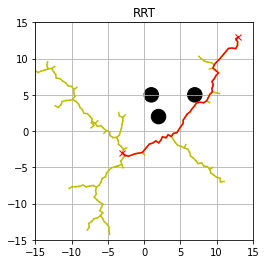

time for RRT:  20.008649869000237


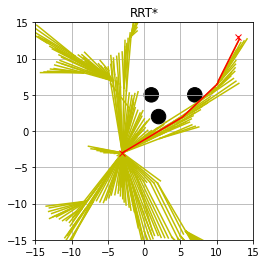

time for RRT*:  42.906088467000245


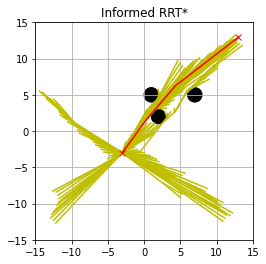

time for Informed RRT*:  39.30039901800001


In [ ]:
if __name__ == '__main__':
        
        # [x,y,size(radius)]
        obs1 = [ (5, 3, 1), (9, 6, 0.5), (7, 6, 1), (1, 5, 1), (2, 2, 1.5), (7, 9, 1), (3.75, 8, 2)]  
        obs2 = [ (6, 5, 0.25), (9, 6, 1), (1, 5, 1), (2, 2, 1), (7, 9, 1)]
        obs3 = [ (1, 5, 1), (2, 2, 1), (7, 5, 1)]
        obs4 = [ (3, 5, 1), (9, 6, 1), (7, 5, 3),  (7, 9, 1)]
        obs5 = [ (5, 3, 1), (9, 6, 0.5), (7, 6, 1), (1, 5, 1), (2, 2, 1.5), (7, 9, 1), (3.75, 8, 2)]  
        
        # Set Initial parameters
        rrt = RRT_Type(start = [-3, -3], goal = [13, 13], randArea = [-30, 30], obstacleList = obs3,maxIter = 1000)
        rrt2 = RRT_Type(start = [-3, -3], goal = [13, 13], randArea = [-30, 30], obstacleList = obs3,maxIter = 1000)
        rrt3 = RRT_Type(start = [-3, -3], goal = [13, 13], randArea = [-30, 30], obstacleList = obs3, maxIter = 300)

        start1 = time.perf_counter()
        path_rrt = rrt.RRT()
        end1 = time.perf_counter()
        start2 = time.perf_counter()
        path_rrtstar = rrt2.RRTStar()
        end2 = time.perf_counter()
        start3 = time.perf_counter()
        path_informrrtstar = rrt3.InformedRRTStar()
        end3 = time.perf_counter()
        # Draw rrt
        
        rrt.plotter()
        plt.plot([x for (x, y) in path_rrt], [y for (x, y) in path_rrt], '-r')
        plt.grid(True)
        plt.title("RRT")
        plt.show()

        
        print("time for RRT: ",end1 - start1)

        # Draw rrt*
        

        rrt2.plotter()
        plt.plot([x for (x, y) in path_rrtstar], [y for (x, y) in path_rrtstar], '-r')
        plt.grid(True)
        plt.title("RRT*")
        plt.show()

        
        print("time for RRT*: ", end2 - start2)
        
        # Draw informed rrt*
        

        rrt3.plotter()
        plt.plot([x for (x, y) in path_informrrtstar], [y for (x, y) in path_informrrtstar], '-r')
        plt.grid(True)
        plt.title("Informed RRT*")
        plt.show()

        
        print("time for Informed RRT*: ", end3 - start3)
        

# More Obtacles

cost RRT*   21.94081315497245
cost inform RRT*   21.56511042235157
cost inform RRT*   21.255952805681805
cost inform RRT*   21.71072351983291


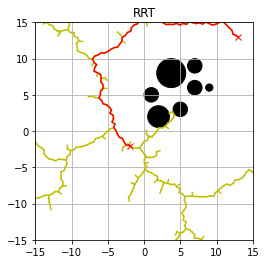

time for RRT:  50.84579717399902


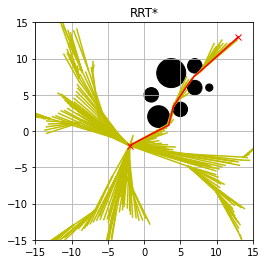

time for RRT*:  50.9975694570021


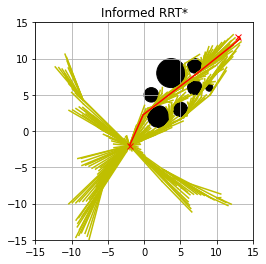

time for Informed RRT*:  95.4761490130004


In [ ]:
if __name__ == '__main__':
        
        # [x,y,size(radius)]
        obs1 = [ (5, 3, 1), (9, 6, 0.5), (7, 6, 1), (1, 5, 1), (2, 2, 1.5), (7, 9, 1), (3.75, 8, 2)]  
        obs2 = [ (6, 5, 0.25), (9, 6, 1), (1, 5, 1), (2, 2, 1), (7, 9, 1)]
        obs3 = [ (1, 5, 1), (2, 2, 1), (7, 9, 1)]
        obs4 = [ (3, 5, 1), (9, 6, 1), (7, 5, 3),  (7, 9, 1)]
        obs5 = [ (5, 3, 1), (9, 6, 0.5), (7, 6, 1), (1, 5, 1), (2, 2, 1.5), (7, 9, 1), (3.75, 8, 2)]  
        
        # Set Initial parameters
        rrt = RRT_Type(start = [-2, -2], goal = [13, 13], randArea = [-30, 30], obstacleList = obs1,maxIter = 5000)

        rrt2 = RRT_Type(start = [-2, -2], goal = [13, 13], randArea = [-30, 30], obstacleList = obs1,maxIter = 5000)
        rrt3 = RRT_Type(start = [-2, -2], goal = [13, 13], randArea = [-30, 30], obstacleList = obs1, maxIter = 500)

        start1 = time.perf_counter()
        path_rrt = rrt.RRT()
        end1 = time.perf_counter()
        start2 = time.perf_counter()
        path_rrtstar = rrt2.RRTStar()
        end2 = time.perf_counter()
        start3 = time.perf_counter()
        path_informrrtstar = rrt3.InformedRRTStar()
        end3 = time.perf_counter()
        # Draw rrt
        
        rrt.plotter()
        plt.plot([x for (x, y) in path_rrt], [y for (x, y) in path_rrt], '-r')
        plt.grid(True)
        plt.title("RRT")
        plt.show()

        
        print("time for RRT: ",end1 - start1)

        # Draw rrt*
        

        rrt2.plotter()
        plt.plot([x for (x, y) in path_rrtstar], [y for (x, y) in path_rrtstar], '-r')
        plt.grid(True)
        plt.title("RRT*")
        plt.show()

        
        print("time for RRT*: ", end2 - start2)
        
        # Draw informed rrt*
        

        rrt3.plotter()
        plt.plot([x for (x, y) in path_informrrtstar], [y for (x, y) in path_informrrtstar], '-r')
        plt.grid(True)
        plt.title("Informed RRT*")
        plt.show()

        
        print("time for Informed RRT*: ", end3 - start3)
        

# Paper type

In [ ]:
import random
import numpy as np 
import math 
import copy 
import matplotlib.pyplot as plt
import time


class Node():

    def __init__(self, x, y):
        self.x = x 
        self.y = y
        self.cost = 0.0 
        self.parent = None 


class RRT_Type():

    def __init__(self, start, goal, obstacleList, randArea, delta=0.5, goalSampleRate=10, maxIter=1000):

        self.start = Node(start[0], start[1])
        self.goal = Node(goal[0], goal[1])
        self.minrand = randArea[0]
        self.maxrand = randArea[1]
        self.delta = delta
        self.goalSampleRate = goalSampleRate
        self.maxIter = maxIter
        self.obstacleList = obstacleList

#RRT
##################################################################################
#Parts of Informed RRT* has been referred from Karan Chawla's Implementation.
    def RRT(self, animation=True):
        self.nodeList = [self.start]
        while True: 
            # get random point in the free space
            rnd = self.getPointSpace()
            # find closest node in the tree
            nind  = self.getNearestListIndex(self.nodeList, rnd)
            nearestNode = self.nodeList[nind]
            theta = math.atan2(rnd[1] - nearestNode.y, rnd[0] - nearestNode.x)
            # compute the position of the new node
            newNode = self.getNewNode(theta, nind, nearestNode)
            # collision check
            if not self.__CollisionCheck(newNode, self.obstacleList):
                continue 
            # if collision doesn't happen in extending the nearest node to the new node
            # add it to the tree
            self.nodeList.append(newNode)

            #check if we reached the goal 
            if self.isNearGoal(newNode):
                break

            if animation:
                self.plotter(rnd)

        # compute the path 
        lastIndex = len(self.nodeList) -1 
        path = self.getFinalCourse(lastIndex)

        return path 

    def getPointSpace(self):
        if random.randint(0,100) > self.goalSampleRate:
            rnd = [random.uniform(self.minrand, self.maxrand),
                   random.uniform(self.minrand, self.maxrand)]
        else:
            rnd = [self.goal.x, self.goal.y]

        return rnd

    def getNearestListIndex(self, nodes, rnd):
        dList = [(node.x - rnd[0])**2 + 
                 (node.y - rnd[1])**2 for node in nodes]
        minIndex = dList.index(min(dList))
        return minIndex

    def getNewNode(self, theta, nind, nearestNode):
        newNode = copy.deepcopy(nearestNode)

        newNode.x += self.delta * math.cos(theta)
        newNode.y += self.delta * math.sin(theta)

        newNode.cost += self.delta
        newNode.parent = nind 
        return newNode

    def __CollisionCheck(self, newNode, obstacleList):
        for (ox, oy, size) in obstacleList:
            dx = ox - newNode.x 
            dy = oy - newNode.y 
            d = (dx**2  + dy**2)**0.5
            if d <= size:
                return False #collision

        return True # safe

    def isNearGoal(self, node):
        d = self.lineCost(node, self.goal)
        if d < self.delta:
            return True 
        return False  

# RRT*
##################################################################################
    def RRTStar(self, animation=True):
        self.nodeList = [self.start]
        iter = 1
        while True:
            rnd = self.getPointSpace()
            nind = self.getNearestListIndex(self.nodeList, rnd)
            nearestNode = self.nodeList[nind]
            # steer 
            theta = math.atan2(rnd[1] - nearestNode.y, rnd[0] - nearestNode.x)
            newNode = self.getNewNode(theta, nind, nearestNode)

            if self.__CollisionCheck(newNode, self.obstacleList):
                nearinds = self.findNearNodes(newNode)
                newNode = self.chooseParent(newNode, nearinds)
                self.nodeList.append(newNode)
                self.rewire(newNode, nearinds)

            iter += 1
            if(iter == self.maxIter):
                break

            if animation:
                self.plotter(rnd)

            if self.isNearGoal(newNode):
                break

        # get path 
        lastIndex = len(self.nodeList) -1 
        path = self.getFinalCourse(lastIndex)
        print("cost RRT*  ",self.nodeList[lastIndex].cost)
    
        return path 

    def rewire(self, newNode, nearInds):
        nnode = len(self.nodeList)
        for i in nearInds:
            nearNode = self.nodeList[i]

            d = math.sqrt((nearNode.x - newNode.x)**2 +
                          (nearNode.y - newNode.y)**2)

            scost = newNode.cost + d

            if nearNode.cost > scost:
                theta = math.atan2(newNode.y - nearNode.y , 
                                   newNode.x - nearNode.x)
                if self.check_collision_extend(nearNode, theta, d):
                    nearNode.parent = nnode - 1
                    nearNode.cost = scost

    def check_collision_extend(self, nearNode, theta, d):
        tmpNode = copy.deepcopy(nearNode)

        for i in range(int(d / self.delta)):
            tmpNode.x += self.delta * math.cos(theta)
            tmpNode.y += self.delta * math.sin(theta)
            if not self.__CollisionCheck(tmpNode, self.obstacleList):
                return False

        return True

    def findNearNodes(self, newNode):
        nnode = len(self.nodeList)
        r = 50.0 * math.sqrt((math.log(nnode) / nnode))
        dlist = [(node.x - newNode.x) ** 2 +
                (node.y - newNode.y) ** 2 for node in self.nodeList]
        nearinds = [dlist.index(i) for i in dlist if i <= r ** 2]
        return nearinds

    def chooseParent(self, newNode, nearInds):
        if len(nearInds) == 0:
            return newNode 

        dList = []
        for i in nearInds:
            dx = newNode.x - self.nodeList[i].x
            dy = newNode.y - self.nodeList[i].y
            d = math.sqrt(dx ** 2 + dy ** 2)
            theta = math.atan2(dy, dx)
            if self.check_collision_extend(self.nodeList[i], theta, d):
                dList.append(self.nodeList[i].cost + d)
            else:
                dList.append(math.inf)

        minCost = min(dList)
        minInd = nearInds[dList.index(minCost)]

        if minCost == math.inf:
            print("mincost is inf")
            return newNode

        newNode.cost = minCost
        newNode.parent = minInd

        return newNode

    def getFinalCourse(self, lastIndex):
        path = [[self.goal.x, self.goal.y]]
        while self.nodeList[lastIndex].parent is not None:
            node = self.nodeList[lastIndex]
            path.append([node.x, node.y])
            lastIndex = node.parent
        path.append([self.start.x, self.start.y])
        return path

    def getBestLastIndex(self):
        disgList = [self.calcDistToGoal(node.x, node.y) 
                    for node in self.nodeList]
        goalInds = [disgList.index(i) for i in disgList if i <= self.delta]

        if len(goalInds) == 0:
            return None 

        minCost = min([self.nodeList[i].cost for i in goalInds])
        for i in goalInds:
            if self.nodeList[i].cost == minCost:
                return i

        return None 

    def calcDistToGoal(self, x, y):
        return np.linalg.norm([x - self.goal.x, y - self.goal.y])

#Informed RRT*
##################################################################################
    def InformedRRTStar(self, animation=True):

        self.nodeList = [self.start]
        # max length we expect to find in our 'informed' sample space, starts as infinite
        cBest = math.inf
        pathLen = math.inf
        treeSize = 0
        pathSize = 0
        solutionSet = set()
        path = None

        # Computing the sampling space 
        cMin = math.sqrt(pow(self.start.x - self.goal.x, 2) + pow(self.start.y - self.goal.y, 2))
        xCenter = np.matrix([[(self.start.x + self.goal.x) / 2.0], [(self.start.y + self.goal.y) / 2.0], [0]])
        a1 = np.matrix([[(self.goal.x - self.start.x) / cMin], [(self.goal.y - self.start.y) / cMin], [0]])
        id1_t = np.matrix([1.0, 0.0, 0.0]) # first column of idenity matrix transposed
        M = np.dot(a1 , id1_t)
        U, S, Vh = np.linalg.svd(M, 1, 1)
        C = np.dot(np.dot(U, np.diag([1.0, 1.0, np.linalg.det(U) * np.linalg.det(np.transpose(Vh))])), Vh)
        
        for i in range(self.maxIter):
            # Sample space is defined by cBest 
            # cMin is the minimum distance between the start point and the goal 
            # xCenter is the midpoint between the start and the goal 
            # cBest changes when a new path is found 

            rnd = self.sample(cBest, cMin, xCenter, C)
            nind = self.getNearestListIndex(self.nodeList, rnd)
            nearestNode = self.nodeList[nind]
            # steer 
            theta = math.atan2(rnd[1] - nearestNode.y, rnd[0] - nearestNode.x)
            newNode = self.getNewNode(theta, nind, nearestNode)
            d = self.lineCost(nearestNode, newNode)
            if self.__CollisionCheck(newNode, self.obstacleList) and self.check_collision_extend(nearestNode, theta, d):
                nearInds = self.findNearNodes(newNode)
                newNode = self.chooseParent(newNode, nearInds)

                self.nodeList.append(newNode)
                self.rewire(newNode, nearInds)

                if self.isNearGoal(newNode):
                    solutionSet.add(newNode)
                    lastIndex = len(self.nodeList) -1 
                    print("cost inform RRT*  ",self.nodeList[lastIndex].cost)
                    tempPath = self.getFinalCourse(lastIndex)
                    tempPathLen = self.getPathLen(tempPath)
                    if tempPathLen < pathLen:
                        path = tempPath
                        cBest = tempPathLen

            if animation:
                self.plotter(rnd)
            
        return path

    def sample(self, cMax, cMin, xCenter, C):
        if cMax < float('inf'):
            r = [cMax /2.0, math.sqrt(cMax**2 - cMin**2)/2.0, 
                            math.sqrt(cMax**2 - cMin**2)/2.0]
            L = np.diag(r)
            xBall = self.sampleUnitBall()
            rnd = np.dot(np.dot(C, L), xBall) + xCenter
            rnd = [rnd[(0,0)], rnd[(1,0)]]
        else:
            rnd = self.getPointSpace()

        return rnd

    def sampleUnitBall(self):
        a = random.random()
        b = random.random()

        if b < a:
            a, b = b, a

        sample = (b * math.cos(2 * math.pi * a / b), 
                  b * math.sin(2 * math.pi * a / b))
        return np.array([[sample[0]], [sample[1]], [0]])

    def getPathLen(self, path):
        pathLen = 0
        for i in range(1, len(path)): 
            node1_x = path[i][0]
            node1_y = path[i][1]
            node2_x = path[i-1][0]
            node2_y = path[i-1][1]
            pathLen += math.sqrt((node1_x - node2_x)**2 + (node1_y - node2_y)**2)

        return pathLen

    def lineCost(self, node1, node2):
        return math.sqrt((node1.x - node2.x)**2 + (node1.y - node2.y)**2)

# Plotting the Graph
##################################################################################
    def plotter(self, rnd=None):

        plt.clf()
        if rnd is not None: 
            plt.plot(rnd[0], rnd[1], "^k")
        for node in self.nodeList:
            if node.parent is not None: 
                if node.x or node.y is not None: 
                    plt.plot([node.x, self.nodeList[node.parent].x], [
                          node.y, self.nodeList[node.parent].y], "-y")

        for (ox, oy, size) in self.obstacleList:
            plt.gcf().gca().add_artist(plt.Circle((ox, oy), size, color='black'))

        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.goal.x, self.goal.y, "xr")  
        plt.axis([-5, 5, -5, 5])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.grid(True)
        #plt.pause(0.01)


cost RRT*   5.910989416871297
cost inform RRT*   3.7050985715767033


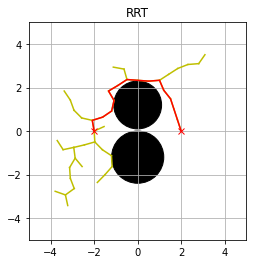

time for RRT:  2.403485172002547


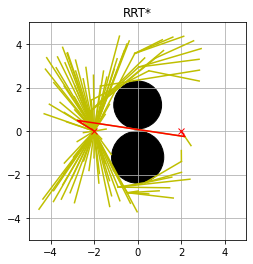

time for RRT*:  9.421090400002868


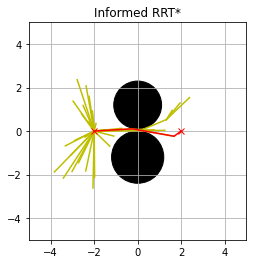

time for Informed RRT*:  2.459838144997775


In [ ]:
if __name__ == '__main__':
        
        # [x,y,size(radius)]
        obs5 = [ (0,1.2,1.1),(0,-1.2,1.2)]  
        rrt = RRT_Type(start = [-2,0], goal = [2, 0], randArea = [-5, 5], obstacleList = obs5,maxIter = 5000)

        rrt2 = RRT_Type(start = [-2, 0], goal = [2, 0], randArea = [-5, 5], obstacleList = obs5,maxIter = 5000)
        rrt3 = RRT_Type(start = [-2, 0], goal = [2, 0], randArea = [-5, 5], obstacleList = obs5, maxIter = 50)

        start1 = time.perf_counter()
        path_rrt = rrt.RRT()
        end1 = time.perf_counter()
        start2 = time.perf_counter()
        path_rrtstar = rrt2.RRTStar()
        end2 = time.perf_counter()
        start3 = time.perf_counter()
        path_informrrtstar = rrt3.InformedRRTStar()
        end3 = time.perf_counter()
        # Draw rrt
        
        rrt.plotter()
        plt.plot([x for (x, y) in path_rrt], [y for (x, y) in path_rrt], '-r')
        plt.grid(True)
        plt.title("RRT")
        plt.show()

        
        print("time for RRT: ",end1 - start1)

        # Draw rrt*
        

        rrt2.plotter()
        plt.plot([x for (x, y) in path_rrtstar], [y for (x, y) in path_rrtstar], '-r')
        plt.grid(True)
        plt.title("RRT*")
        plt.show()

        
        print("time for RRT*: ", end2 - start2)
        
        # Draw informed rrt*
        

        rrt3.plotter()
        plt.plot([x for (x, y) in path_informrrtstar], [y for (x, y) in path_informrrtstar], '-r')
        plt.grid(True)
        plt.title("Informed RRT*")
        plt.show()

        
        print("time for Informed RRT*: ", end3 - start3)
        
        